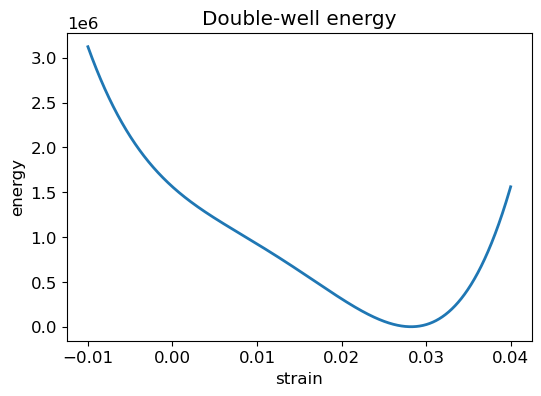

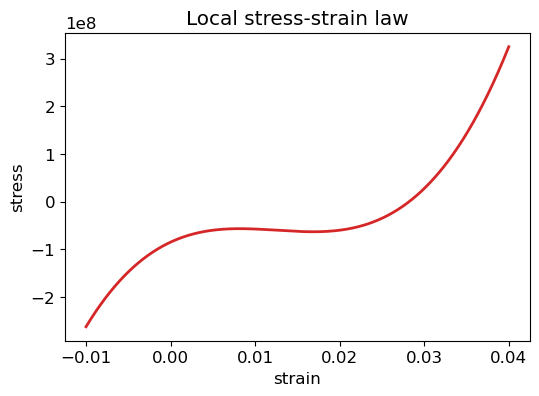

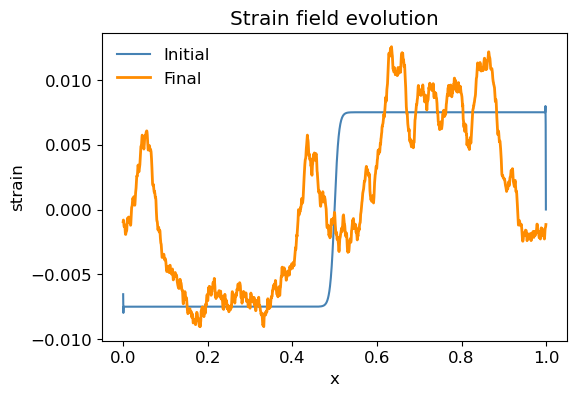

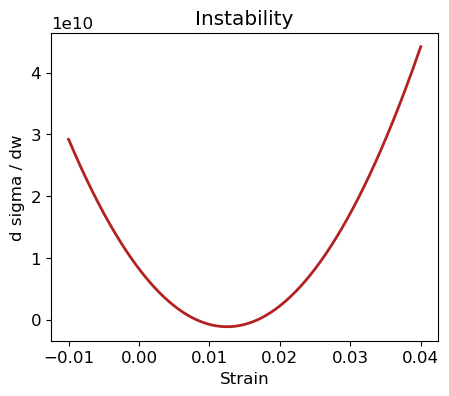

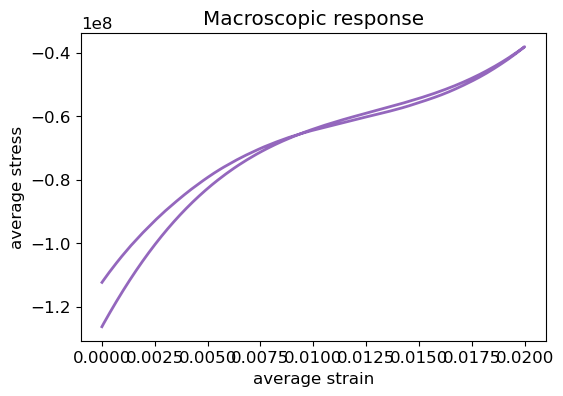


Check:
Mean(w_final) = 6.640000e-04
w_bar(final)  = 4.000000e-06


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display

# ============================================================
# Plot style 
# ============================================================
plt.rcParams.update({
    "font.size": 12,
    "figure.figsize": (6,4),
    "lines.linewidth": 2
})

c_energy = "#1f77b4"   # blue
c_sigma  = "#d62728"   # red
c_field1 = "#2ca02c"   # green
c_field2 = "#ff7f0e"   # orange
c_eff    = "#9467bd"   # purple

# ============================================================
# 0) Parameters
# ============================================================
L = 1.0
rho0 = 1.0

E_ref = 1e9
eps = 1e5
alpha = 2.0 * eps / rho0

Nx = 2000
dx = L / Nx
x = np.linspace(0.0, L, Nx, endpoint=False)

dt = 2e-10
Tend = 2e-6
nstep = int(Tend/dt)

nb_image = 150
nprint = max(1, nstep // nb_image)

# ============================================================
# 1) Non-convex constitutive law
# ============================================================
w1 = 0.005
w2 = 0.020

A = 2e13
tau = 6e7

def Phi_dw(w):
    return (A/4.0) * (w - w1)**2 * (w - w2)**2

def Phi(w):
    return Phi_dw(w) - tau*w

def sigma_dw(w):
    return (A/2.0) * (w - w1) * (w - w2) * (2.0*w - w1 - w2)

def sigma(w):
    return sigma_dw(w) - tau

# ============================================================
# FIGURE 1 — Energy
# ============================================================
wplot = np.linspace(-0.01, 0.04, 2000)
Phi_rel = Phi(wplot) - Phi(wplot).min()

plt.figure()
plt.plot(wplot, Phi_rel, color=c_energy)
plt.xlabel("strain")
plt.ylabel("energy")
plt.title("Double-well energy")
plt.show()

# ============================================================
# FIGURE 2 — Local law
# ============================================================
sigplot = sigma(wplot)

plt.figure()
plt.plot(wplot, sigplot, color=c_sigma)
plt.xlabel("strain")
plt.ylabel("stress")
plt.title("Local stress-strain law")
plt.show()

# ============================================================
# 2) Spatial operators (periodic FD)
# ============================================================
def ddx(f):
    return (np.roll(f, -1) - np.roll(f, 1)) / (2*dx)

def d4x(f):
    return (np.roll(f, -2) - 4*np.roll(f, -1) + 6*f
            - 4*np.roll(f, 1) + np.roll(f, 2)) / (dx**4)

# ============================================================
# 3) Macroscopic cyclic loading
# ============================================================
wmin, wmax = 0.0, 0.020
Tcycle = Tend

def w_bar(t):
    tau_c = (t % Tcycle) / Tcycle
    if tau_c < 0.5:
        return wmin + 2.0*tau_c*(wmax - wmin)
    else:
        return wmax - 2.0*(tau_c - 0.5)*(wmax - wmin)

# ============================================================
# 4) Dynamics
# ============================================================
def acceleration(u_tilde, t):
    w = w_bar(t) + ddx(u_tilde)
    return ddx(sigma(w)) / rho0 - alpha * d4x(u_tilde)

# ============================================================
# 5) Initial condition (phase front)
# ============================================================
width = 0.01 * L
w_jump = 0.5*(w2 - w1) * (1.0 + np.tanh((x - 0.5*L)/width)) + w1

w0_fluct = w_jump - np.mean(w_jump)

u = np.cumsum(w0_fluct) * dx
u -= np.mean(u)

v = np.zeros_like(u)

# ============================================================
# 6) Time integration (Velocity-Verlet)
# ============================================================
wOfTime = np.zeros((Nx, nb_image))
snap_t = np.zeros(nb_image)

weff = np.zeros(nstep)
seff = np.zeros(nstep)

a = acceleration(u, 0.0)

snap = 0
for n in range(nstep):
    t = n * dt

    u_new = u + dt*v + 0.5*dt**2 * a
    a_new = acceleration(u_new, t + dt)
    v_new = v + 0.5*dt*(a + a_new)

    u, v, a = u_new, v_new, a_new

    w_field = w_bar(t) + ddx(u)
    weff[n] = np.mean(w_field)
    seff[n] = np.mean(sigma(w_field))

    if (n % nprint == 0) and (snap < nb_image):
        wOfTime[:, snap] = w_field
        snap_t[snap] = t
        snap += 1

# ============================================================
# FIGURE 3 — Strain field
# ============================================================
plt.figure()
plt.plot(x, wOfTime[:, 0], color='steelblue', linewidth=1.5, label="Initial")
plt.plot(x, wOfTime[:, snap-1], color='darkorange', linewidth=2, label="Final")
plt.xlabel("x")
plt.ylabel("strain")
plt.legend(frameon=False)
plt.title("Strain field evolution")
plt.show()

# ============================================================
# FIGURE 3 — Instability (spinodal)
# ============================================================
dsig = np.gradient(sigplot, wplot)

plt.figure(figsize=(5,4))
plt.plot(wplot, dsig, color='firebrick', linewidth=2)
plt.title("Instability")
plt.xlabel("Strain")
plt.ylabel("d sigma / dw")
plt.show()



# ============================================================
# FIGURE 4 — Macroscopic response
# ============================================================
plt.figure()
plt.plot(weff, seff, color=c_eff)
plt.xlabel("average strain")
plt.ylabel("average stress")
plt.title("Macroscopic response")
plt.show()

# ============================================================
# Animation 
# ============================================================
fig, ax = plt.subplots()
line, = ax.plot(x, wOfTime[:, 0], color=c_field2)
ax.set_xlabel("x")
ax.set_ylabel("strain")
ax.set_title("Strain evolution")

def animate(i):
    line.set_ydata(wOfTime[:, i])
    return (line,)

ani = animation.FuncAnimation(fig, animate, frames=range(snap),
                              interval=40, blit=True)
display(HTML(ani.to_jshtml()))
plt.close(fig)

# ============================================================
# Check
# ============================================================
print("\nCheck:")
print(f"Mean(w_final) = {np.mean(wOfTime[:, snap-1]):.6e}")
print(f"w_bar(final)  = {w_bar((nstep-1)*dt):.6e}")
